<a href="https://colab.research.google.com/github/Bryan-Az/Neurobytes/blob/notebooks/mlops/notebooks/users_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of the Synthetic User Preferences


## Spotify Million Song Dataset (Via Kaggle)
This synthetic dataset was generated with the Kaggle 'Spotify Million Song' dataset.

The original data contains the features:

- 'artist': The name of the artist
- 'song': The name of the song
- 'text': The song lyrics
- 'link': The link to the song via spotify api

A sample of 10,000 rows was selected from this dataset to calculate synthetic user preferences, as the original dataset is very large. The document-term matrix was calculated, where each song is a document and the words in the lyrics are the terms.

## Synthetic User Preference Data

The cosin similarity was calculated, representing the similarity between from songs-to-songs by their lyrics. This data was then used to calculate synthetic user data by sampling a 'starter' song for each user, and then using the top 3 similar songs to the original song as their sample user preferences. Then, the following two columns were added to a new user preferences dataset:

- 'songID': a many-to-one foreign key to the original song dataset.
- 'userID': a many-to-one userID index.

Our synthetic user prefernce generator selects n_starter songs and then uses cosin similarity to select n further top-n similar songs for the original n_starter song, such that each user will have a variety of 'tastees'.

 For example, each 'song cluster' sample (n_starter) includes self (original song) with similarity of 1, then included n similar songs (starter song + n similar songs).
  
  To calculate the size, for example, n = 3, songs_per_user = 50, num_users=1000
  returns: num_users * (n + 1) * (songs_per_user) = ~200,000 preferences (variable as n_starter is random value between 40-50).



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

In [61]:
! pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [73]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [136]:
users_lyrics_only_glink = 'https://drive.google.com/file/d/1fw3kszKGlaz4x6oMgCMNmY_s3ejwdGxT/view?usp=drive_link'
lyrics_only_filename = 'user_preferences_lyrics_only.csv'

In [137]:
users_artist_lyrics_glink = 'https://drive.google.com/file/d/1v1aXLG-PoTR6-UqJGQml-heLoPz8Lu-R/view?usp=drive_link'
users_artist_lyrics_filename = 'user_preferences.csv'

In [138]:
def get_link_content(link, name):
  file_id = link.split('/')[-2]
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

In [139]:
get_link_content(users_lyrics_only_glink, lyrics_only_filename)
get_link_content(users_artist_lyrics_glink, users_artist_lyrics_filename)

In [160]:
user_lyrics_only_preferences = pd.read_csv(lyrics_only_filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [161]:
user_preferences = pd.read_csv(users_artist_lyrics_filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [162]:
print(user_lyrics_only_preferences.shape)
print(user_preferences.shape)

(178340, 6)
(178136, 6)


# Identifying the 'Favorite'/'Most Listened' to Artist's

As the algorithm to generate synthetic user preferences assigned users clusters of songs that had fairly similar cosin similarity (at random, based on samples of the main dataset) using the lyric information, every user should have a different set of artists and a different ranking of artists by # songs within the user preferences dataset.

In [163]:
preference_size_distribution_lyrics_only = user_lyrics_only_preferences.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution_lyrics_only

count    1000.000000
mean      178.340000
std        11.171804
min       160.000000
25%       168.000000
50%       180.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [164]:
preference_size_distribution = user_preferences.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution

count    1000.000000
mean      178.136000
std        11.492675
min       160.000000
25%       168.000000
50%       176.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [180]:
sample_user_lyrics_only = user_lyrics_only_preferences.where(user_lyrics_only_preferences['userID'] == user_lyrics_only_preferences['userID'].sample(1).iloc[0]).dropna() # a sample user

In [181]:
sample_user_lyrics_only.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Z-Ro             5.0
Randy Travis     4.0
Kelly Family     3.0
Who              3.0
Marillion        3.0
John Denver      3.0
Green Day        3.0
Black Sabbath    2.0
Ramones          2.0
J Cole           2.0
dtype: float64

In [182]:
sample_user_preferences = user_preferences.where(user_preferences['userID'] == user_preferences['userID'].sample(1).iloc[0]).dropna()

In [183]:
sample_user_preferences.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Neil Diamond       4.0
Elvis Presley      4.0
Point Of Grace     4.0
Usher              4.0
Iron Maiden        3.0
The Monkees        3.0
Styx               3.0
Cher               3.0
Michael Jackson    3.0
Reba Mcentire      3.0
dtype: float64

Given a sample user, it seems that identifying their 'favorite' artist would be a tough choice to make. The majority of artists within this sample user's preferences only make one or two appearances, and any artist with more than 3 appearances is very rare.

My theory is that given that 'artist' name was not used as input to the cosin similarity algorithm, it could be ignoring the artist's identities when making recommendations, and user preferences do not seem to skew to any particular artist.

<Axes: >

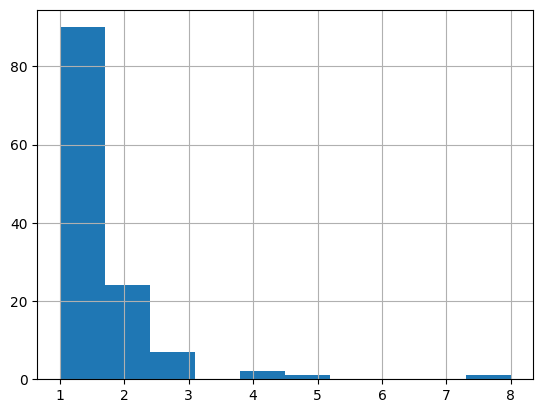

In [184]:
# plotting the distribution of artist count for the sample user
sample_user.groupby('artist').count().mean(axis=1).hist(bins=10)

By visualizing the same distribution - this time using the entire user preferences dataset - we can see that most artists make an appearance within a user's library 1-3 times, with a small right tail skewing the distribution towards 4-8 appearances.

Perhaps including the artist's name or the album name into the document-term matrix before generating the synthetic user preferences would allow for a more concentrated selection of choices that might mimic how individual user's tend to favor entire albums or playlists centered around a particular artist.

<Axes: >

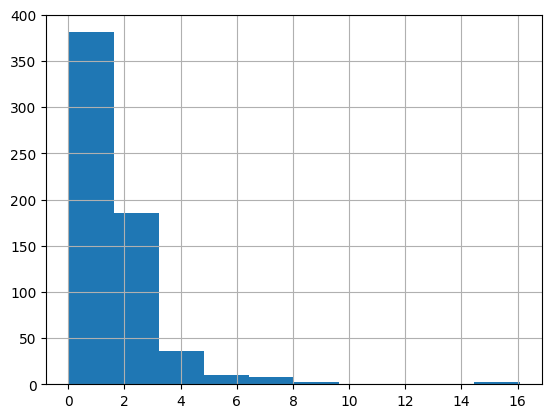

In [185]:
# plotting similar distribution using the entire dataset
(user_lyrics_only_preferences.groupby('artist').count() / preference_size_distribution_lyrics_only['mean']).mean(axis=1).hist(bins=10)

It looks like reducing the lyrics to only the top 5 words (as in the below plot) along with the artist name (instead of just the lyrics as in the above plot) had a small effect on the skew of the distribution on the number of songs individual artist's have on a user's preferences.

<Axes: >

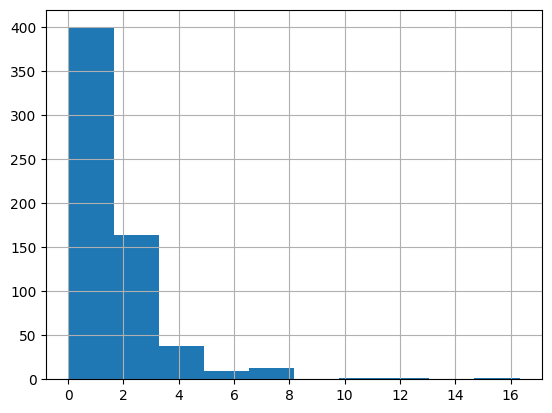

In [186]:
(user_preferences.groupby('artist').count() / preference_size_distribution['mean']).mean(axis=1).hist(bins=10)

Including the entire lyrics dataset along with the artist name will bias the similarity calculation, so instead, only the top 5 most frequent words in the lyrics will be included, to allow for artist name to be given a higher weight.

In [170]:
user_lyrics_only_preferences['artist'].apply(lambda x: len(x.split(' '))).mean() # artist name tends to have 1-2 words

1.8051082202534485

In [171]:
user_lyrics_only_preferences['text'].apply(lambda x: len(x.split(' '))).mean() # lyrics tend to have 337! words

337.1851575642032

In [172]:
# lets make a function to select only the top n words in the lyrics
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
def top_n_words(text, n):
  freq_dist = FreqDist(word_tokenize(text))
  # remove filler words
  freq_dist = FreqDist({key: val for key, val in freq_dist.items() if key not in nltk.corpus.stopwords.words('english')})
  # select only the words from the (word, freq) tuple list
  words = ' '.join([word for word, freq in freq_dist.most_common()])
  return words

In [192]:
top_words_lyrics_only = sample_user_lyrics_only['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [193]:
top_words_lyrics_only.iloc[0] # concatenates the top 5 words for each of the songs in the user's preferences

"? [ Chorus ] This They let To us 'd We held And If Two months little go sudden healing think providence would Take child mother prays Is appalling Who told rescued What changed saved nightmares 're asking happens died live It 's unfair means How feels sacred torn life survive loved know promise When everything fell hand bitterness want taste , hatred numb sorrow The wise hands opens slowly lilies valley tomorrow hope born suffering beginning Can wait one hour watching Savior"

In [194]:
top_words = sample_user_preferences['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [195]:
top_words.iloc[0] # concatenates the top 5 words for each of the songs in the user's preferences

"I You ride And But 'm [ Chorus ] 's day ( ) til die When Just like n't say It ' We forget 'Cause That mind boy figure : Repeat x2 everything thought make Now look back time spent see Playing right got breaking ca Of 'll let Ride real late 'Bout quarter one Thinkin everythang become hate could ready scratch wan na saw pictures letters sent thinkin friends foolish Treat stupid oh Visions met showed thangs never Took swimming In ocean head clouds Make feel floating yeah think playing truth Nobody else Quite All kisses lovin ai nobody Better us guess definitely know Its easy To go planned start blame 'cause blew wo Sweet baby This game ends somehow Might believe finna wish come hold lonely need someone talk would phone Boy forgot promises made memories fade away remember What used"

In [175]:
# visualization of the sample users top_n words using a word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white')

In [187]:
sample_user_artists_lyrics_only = ' '.join(sample_user_lyrics_only['artist'].tolist())
sample_user_artists_lyrics_only

'Natalie Grant Ice Cube Outkast Bosson Ice Cube Kelly Family Ween Notorious B.I.G. Marillion Chris Brown Z-Ro Leo Sayer Leo Sayer Counting Crows Oingo Boingo Kanye West Chris Brown Black Sabbath Kid Rock Michael Buble Bob Seger Willie Nelson Youngbloodz Ramones The Beatles Marillion Oingo Boingo Dream Theater Leonard Cohen Dire Straits Ella Fitzgerald P!nk Bob Dylan Kiss Paul McCartney Ray Boltz Ray Boltz Dan Fogelberg Hanson Willie Nelson Bob Dylan George Harrison Xzibit Rascal Flatts Lil Wayne Green Day Point Of Grace Wu-Tang Clan Gary Numan John Denver Who Who Green Day Queen Latifah Everlast Z-Ro Z-Ro Jennifer Lopez Ne-Yo J Cole Styx Black Sabbath Clash Green Day Status Quo Gordon Lightfoot Alabama David Bowie Air Supply Who Death Bruce Springsteen Bruce Springsteen Tom Waits Neil Sedaka Randy Travis Randy Travis Tom T. Hall Phish Korn James Taylor Van Morrison Jennifer Lopez Wilson Pickett Santana George Harrison Veruca Salt John Denver Dean Martin Cliff Richard Devo Hank Snow Dol

In [188]:
sample_user_artists_artist_lyrics = ' '.join(sample_user_preferences['artist'].tolist())
sample_user_artists_artist_lyrics

"Rihanna Usher Linda Ronstadt X Japan Coldplay Guns N' Roses High School Musical Luther Vandross Adele Poison Natalie Cole Ten Years After Ten Years After Usher Neil Diamond Violent Femmes Phil Collins Michael Buble Olivia Newton-John Point Of Grace Faces Cher Backstreet Boys Reba Mcentire Dusty Springfield Leann Rimes John Prine Diana Ross Elvis Presley Mary Black Mary Black Lea Salonga Kenny Rogers Counting Crows Black Sabbath Rihanna Isley Brothers Omd Omd Hollies Lucky Dube ZZ Top Harry Connick, Jr. Queen ZZ Top Nina Simone Neil Diamond Uriah Heep Whitesnake Kelly Family Norah Jones Marilyn Manson Michael Jackson Michael Bolton The Monkees Queen Adreena Face To Face The Monkees Michael Jackson Hillsong Hillsong United Indiana Bible College Backstreet Boys Hillsong United Carly Simon Gary Valenciano Britney Spears Gary Numan Usher Luther Vandross One Direction Christina Aguilera Kelly Family Leann Rimes Yoko Ono Kelly Clarkson Kyla Bon Jovi King Diamond Kirk Franklin Journey Jimmy B

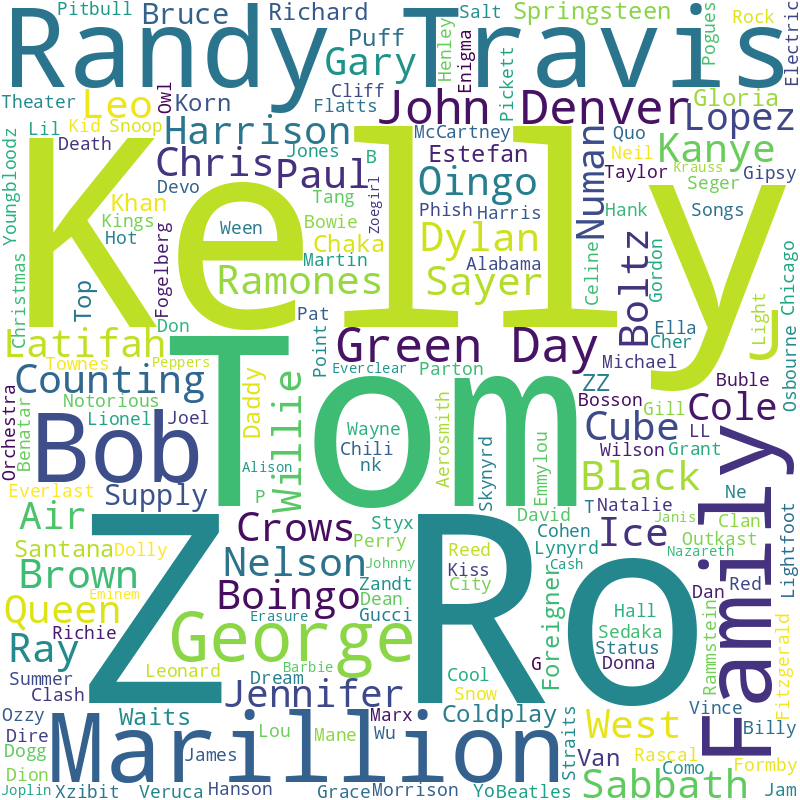

In [189]:
wordcloud.generate(sample_user_artists_lyrics_only).to_image() # word cloud of sample users artist preferences

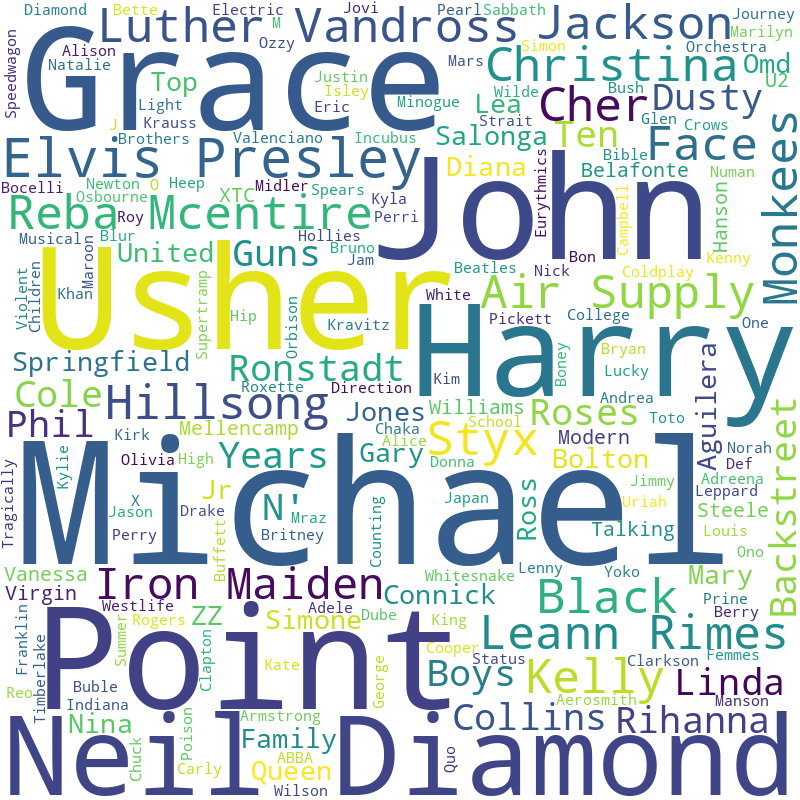

In [190]:
wordcloud.generate(sample_user_artists_artist_lyrics).to_image() # word cloud of sample users artist preferences

In [196]:
sample_user_words_lyrics_only = ' '.join(top_words_lyrics_only.tolist())
sample_user_words_lyrics_only

"? [ Chorus ] This They let To us 'd We held And If Two months little go sudden healing think providence would Take child mother prays Is appalling Who told rescued What changed saved nightmares 're asking happens died live It 's unfair means How feels sacred torn life survive loved know promise When everything fell hand bitterness want taste , hatred numb sorrow The wise hands opens slowly lilies valley tomorrow hope born suffering beginning Can wait one hour watching Savior I , ' 'm 's 'cause got n't Cube get ya ? wit wanted Ice The nigga ca 'll ( ) know shit yo keep one crew beat put house see Lench Mob goin time way scarin ai son ol So They day still AmeriKKKa Back dirt people But fat jack catch dig sweat em mad Hey said rings It tried ta ! ass fuck bitch back robbin A livin city criminal zone One law order everybody crazy quarter You 're tuned number area talkin darin raise hell bail brag sag flag gang banger Keep chamber things 4-1-1 All school fellows crooks jealous looks thinki

In [200]:
sample_user_words = ' '.join(top_words.tolist())
sample_user_words

"I You ride And But 'm [ Chorus ] 's day ( ) til die When Just like n't say It ' We forget 'Cause That mind boy figure : Repeat x2 everything thought make Now look back time spent see Playing right got breaking ca Of 'll let Ride real late 'Bout quarter one Thinkin everythang become hate could ready scratch wan na saw pictures letters sent thinkin friends foolish Treat stupid oh Visions met showed thangs never Took swimming In ocean head clouds Make feel floating yeah think playing truth Nobody else Quite All kisses lovin ai nobody Better us guess definitely know Its easy To go planned start blame 'cause blew wo Sweet baby This game ends somehow Might believe finna wish come hold lonely need someone talk would phone Boy forgot promises made memories fade away remember What used I U ya help n't love need know , And Tell wan na without girl Girl 're want Can got You world Baby crazy 's alone Oh Ca live make leave Without whole falling apart Life prison 'll u But try thought 'm understand

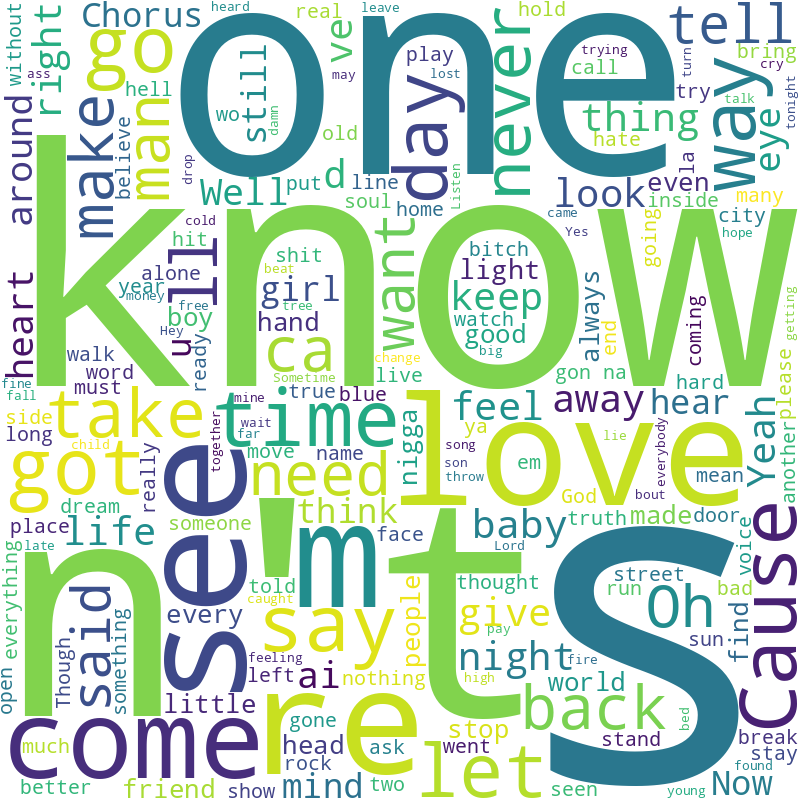

In [197]:
wordcloud.generate(sample_user_words_lyrics_only).to_image() # word cloud of sample user's lyric preferences

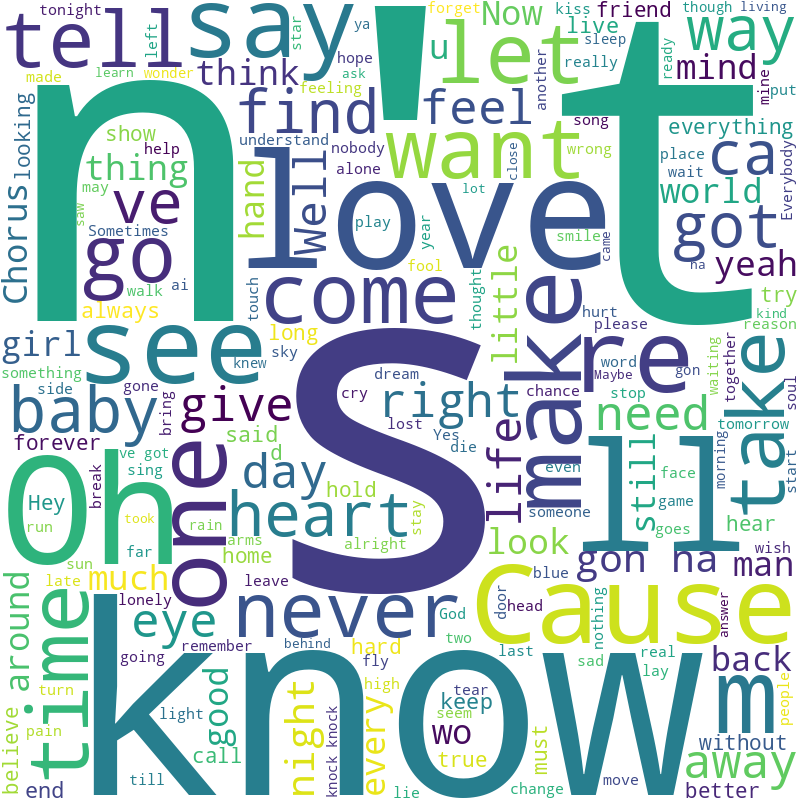

In [201]:
wordcloud.generate(sample_user_words).to_image() # word cloud of sample user's lyric preferences